In [1]:
import torch

In [2]:
import sys
sys.path.insert(0, '../../../modules/')

In [3]:
from nn_rbf_phs import RBFInterpolant
from notable_functions import franke_func
def d_meshgrid(*args):
    # Create grid coordinates along each dimension
    grid = torch.meshgrid(*args)
    # Convert the grid coordinates to tensors
    grid_tensors = [coord.flatten() for coord in grid]
    # Stack the grid tensors along a new dimension to create the d-dimensional meshgrid
    meshgrid = torch.stack(grid_tensors, dim=-1)
    return meshgrid

In [4]:
grid_verification = d_meshgrid(*[torch.linspace(0, 1, 300) for _ in range(2)])
target_verification = franke_func(grid_verification)

/home/higlesias/.anaconda3/envs/tfm/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201450/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Script for computing l2, linf norms

In [5]:
profiles = [5,10,15,20,25,30,35,40,45,70,75,80,85,90,95,100,105]
l2_norm, linf_norm = [0.] * len(profiles), [0.] * len(profiles)
l2_norm_inv, linf_norm_inv = [0.] * len(profiles), [0.] * len(profiles)
l2_norm_solve, linf_norm_solve = [0.] * len(profiles), [0.] * len(profiles)

In [6]:
z_target_ver = target_verification.squeeze()

In [7]:
i = 0
with torch.no_grad():
    for N in profiles:
        grid = d_meshgrid(*[torch.linspace(0, 1, N) for _ in range(2)])
        target = franke_func(grid)

        experiment_string = f'{franke_func.__name__}_interpolation_dim{2}_N{N}_r{3}_deg{-1}'

        nn_trained = RBFInterpolant(1, grid)
        import csv
        import os
        if os.path.exists(f'experiments_csv/{experiment_string}.csv'):
            with open(f'experiments_csv/{experiment_string}.csv', 'r') as csvfile:
                csv_reader = csv.reader(csvfile)
                # Read the last line of the file
                last_line = None
                for row in csv_reader:
                    last_line = row
                if last_line is not None:
                    coefficients = [float(val) for val in last_line[:-1]]
                    nn_trained = RBFInterpolant(1, grid, coefficients)
        else:
            print('smth went wrong')
            break
        
        coefs_optimum = torch.linalg.inv(nn_trained.get_interpolation_matrix()) @ target
        nn_untrained = RBFInterpolant(1, grid, coefs_optimum)

        coefs_solve = torch.linalg.solve(nn_trained.get_interpolation_matrix(), target)
        nn_solve = RBFInterpolant(1, grid, coefs_solve)
        
        z_trained_ver = nn_trained(grid_verification).squeeze()
        z_untrained_ver = nn_untrained(grid_verification).squeeze()
        z_solve_ver = nn_solve(grid_verification).squeeze()

        l2_norm[i] = torch.linalg.norm((z_target_ver - z_trained_ver) / len(z_target_ver))
        linf_norm[i] = torch.norm((z_target_ver - z_trained_ver), p=torch.inf).numpy()
        l2_norm_inv[i] = torch.linalg.norm((z_target_ver - z_untrained_ver) / len(z_target_ver))
        linf_norm_inv[i] = torch.norm((z_target_ver - z_untrained_ver), p=torch.inf).numpy()
        l2_norm_solve[i] = torch.linalg.norm((z_target_ver - z_solve_ver) / len(z_target_ver))
        linf_norm_solve[i] = torch.norm((z_target_ver - z_solve_ver), p=torch.inf).numpy()

        i = i + 1

/home/higlesias/tfm-experiments/interpolation_comparison/rbf/phs_nd/../../../modules/nn_rbf_phs.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coefs = torch.nn.Parameter(torch.tensor(coefs))


In [8]:
l2_norm

[tensor(0.0001),
 tensor(1.8154e-05),
 tensor(1.8585e-05),
 tensor(1.6809e-05),
 tensor(1.6223e-05),
 tensor(1.6540e-05),
 tensor(1.6483e-05),
 tensor(1.6505e-05),
 tensor(1.6626e-05),
 tensor(5.3473e-05),
 tensor(0.0001),
 tensor(5.3023e-05),
 tensor(8.6735e-05),
 tensor(0.0001),
 tensor(0.0001),
 tensor(0.0002),
 tensor(0.0001)]

In [9]:
linf_norm

[array(0.10058475, dtype=float32),
 array(0.03736523, dtype=float32),
 array(0.04256575, dtype=float32),
 array(0.03892581, dtype=float32),
 array(0.03741018, dtype=float32),
 array(0.03796494, dtype=float32),
 array(0.04200101, dtype=float32),
 array(0.04426551, dtype=float32),
 array(0.04718637, dtype=float32),
 array(0.08823293, dtype=float32),
 array(0.16134766, dtype=float32),
 array(0.07027817, dtype=float32),
 array(0.17162514, dtype=float32),
 array(0.08643401, dtype=float32),
 array(0.14959028, dtype=float32),
 array(0.1721125, dtype=float32),
 array(0.0958159, dtype=float32)]

In [10]:
import torch
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,3))
plt.semilogy(l2_norm, marker='o', linestyle='-.', linewidth=0.5, label='L2 (trained)')
plt.semilogy(linf_norm, marker='o', linestyle='-.', linewidth=0.5, label='Linf (trained)')
plt.semilogy(l2_norm_inv, marker='^', linestyle='-.', linewidth=0.5, label='L2 (inv)')
plt.semilogy(linf_norm_inv, marker='^', linestyle='-.', linewidth=0.5, label='Linf (inv)')
plt.semilogy(l2_norm_solve, marker='*', linestyle='-.', linewidth=0.5, label='L2 (solve)')
plt.semilogy(linf_norm_solve, marker='*', linestyle='-.', linewidth=0.5, label='Linf (solve)')
plt.xticks(range(0,len(profiles)), profiles)
plt.xlabel('N')
plt.title('Conditioning of the interpolation problem (Franke function)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
pp = PdfPages('franke_norms_results_all.pdf')
pp.savefig(fig, bbox_inches='tight')

pp.close()
plt.close()

In [11]:
import torch
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,3))
plt.semilogy(l2_norm, marker='o', linestyle='-.', linewidth=0.5, label='L2 (trained)')
plt.semilogy(linf_norm, marker='o', linestyle='-.', linewidth=0.5, label='Linf (trained)')
plt.semilogy(l2_norm_inv, marker='^', linestyle='-.', linewidth=0.5, label='L2 (inv)')
plt.semilogy(linf_norm_inv, marker='^', linestyle='-.', linewidth=0.5, label='Linf (inv)')
plt.xticks(range(0,len(profiles)), profiles)
plt.xlabel('N')
plt.title('Conditioning of the interpolation problem (Franke function)')
plt.legend()
pp = PdfPages('franke_norms_results_inv.pdf')
pp.savefig(fig, bbox_inches='tight')
pp.close()
plt.close()

In [20]:
experiment_string = f'{franke_func.__name__}_interpolation_dim{2}_N{N}_r{3}_deg{-1}'

In [21]:
nn_trained = RBFInterpolant(1, grid)
import csv
import os
if os.path.exists(f'experiments_csv/{experiment_string}.csv'):
    with open(f'experiments_csv/{experiment_string}.csv', 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        # Read the last line of the file
        last_line = None
        for row in csv_reader:
            last_line = row
        if last_line is not None:
            coefficients = [float(val) for val in last_line[:-1]]
            nn_trained = RBFInterpolant(1, grid, coefficients)


In [22]:
# coefs_opimum = torch.linalg.solve(nn_trained.get_interpolation_matrix(), target)
coefs_optimum = torch.linalg.inv(nn_trained.get_interpolation_matrix()) @ target
nn_untrained = RBFInterpolant(1, grid, coefs_optimum)

/home/higlesias/tfm-experiments/interpolation_comparison/rbf/phs_nd/../../../modules/nn_rbf_phs.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coefs = torch.nn.Parameter(torch.tensor(coefs))


In [46]:
z_target = target.squeeze()  # Convert target tensor to 1D array
z_untrained = nn_untrained(grid).squeeze()  # Convert target tensor to 1D array
z_trained = nn_trained(grid).squeeze()

In [47]:
z_target_ver = target_verification.squeeze()
z_untrained_ver = nn_untrained(grid_verification).squeeze()
z_trained_ver = nn_trained(grid_verification).squeeze()

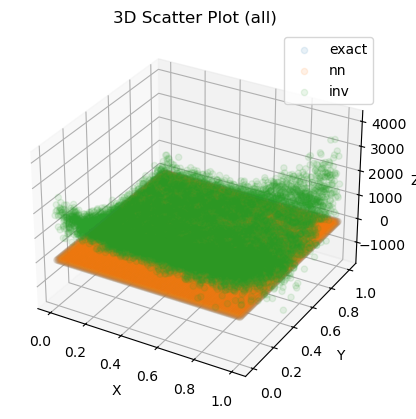

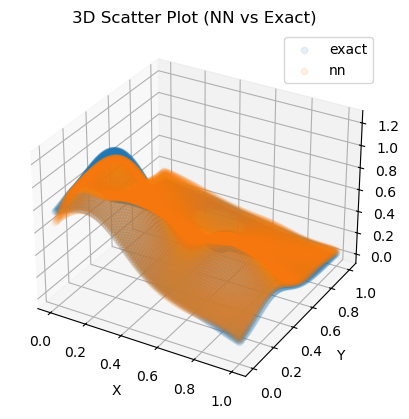

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

with torch.no_grad():
    # Extract x, y, and z coordinates
    x = grid[:, 0]
    y = grid[:, 1]

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot the points
    ax.scatter(x, y, target.squeeze(), label='exact', alpha=.1)
    ax.scatter(x, y, z_trained, label='nn', alpha=.1)
    ax.scatter(x, y, z_untrained, label='inv', alpha=.1)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot (all)')


    plt.legend()
    plt.show()

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot the points
    ax.scatter(x, y, target.squeeze(), label='exact', alpha=.1)
    ax.scatter(x, y, z_trained, label='nn', alpha=.1)


    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot (NN vs Exact)')


    plt.legend()
    plt.show()



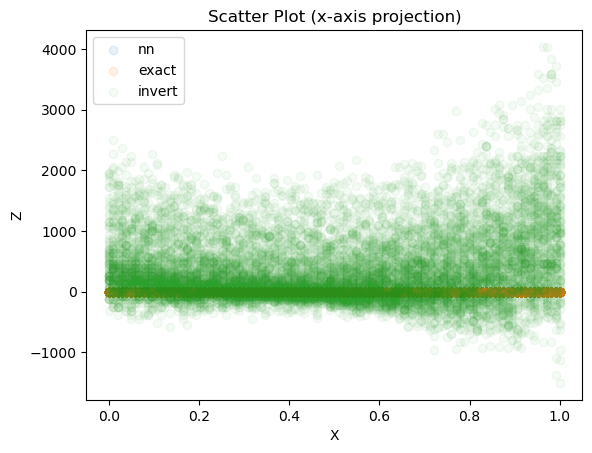

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

with torch.no_grad():
    # Extract x, y, and z coordinates
    x = grid[:, 0]
    y = grid[:, 1]

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Scatter plot the points
    ax.scatter(x, target.squeeze(), label='nn', alpha=.1)
    ax.scatter(x, z_trained, label='exact', alpha=.1)
    ax.scatter(x, z_untrained, label='invert', alpha=.05)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_title('Scatter Plot (x-axis projection)')


    plt.legend()
    plt.show()


L2 and Linf norms

In [42]:
torch.linalg.norm((z_target_ver - z_trained_ver) / len(z_target_ver))

tensor(3.0752e-05, grad_fn=<LinalgVectorNormBackward0>)

In [43]:
torch.norm((z_target_ver - z_trained_ver), p=torch.inf)

tensor(0.0958, grad_fn=<LinalgVectorNormBackward0>)

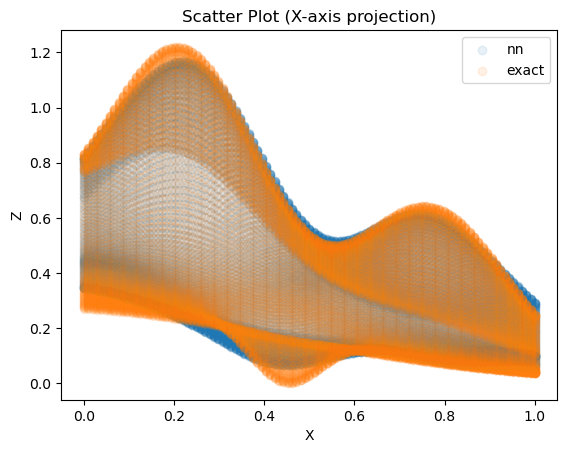

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

with torch.no_grad():
    # Extract x, y, and z coordinates
    x = grid[:, 0]
    y = grid[:, 1]

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Scatter plot the points
    ax.scatter(x, z_trained, label='nn', alpha=.1)
    ax.scatter(x, z_target, label='exact', alpha=.1)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_title('Scatter Plot (X-axis projection)')


    plt.legend()
    plt.show()


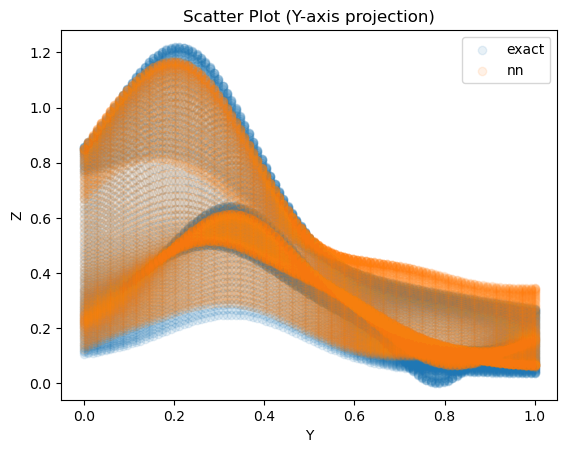

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

with torch.no_grad():
    # Extract x, y, and z coordinates
    x = grid[:, 0]
    y = grid[:, 1]

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Scatter plot the points
    ax.scatter(y, z_target, label='exact', alpha=.1)
    ax.scatter(y, z_trained, label='nn', alpha=.1)

    # Set labels and title
    ax.set_xlabel('Y')
    ax.set_ylabel('Z')
    ax.set_title('Scatter Plot (Y-axis projection)')


    plt.legend()
    plt.show()


----

In [32]:
grid

tensor([[0.0000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 1.0000],
        [0.0000, 1.5000],
        [0.0000, 2.0000],
        [0.5000, 0.0000],
        [0.5000, 0.5000],
        [0.5000, 1.0000],
        [0.5000, 1.5000],
        [0.5000, 2.0000],
        [1.0000, 0.0000],
        [1.0000, 0.5000],
        [1.0000, 1.0000],
        [1.0000, 1.5000],
        [1.0000, 2.0000],
        [1.5000, 0.0000],
        [1.5000, 0.5000],
        [1.5000, 1.0000],
        [1.5000, 1.5000],
        [1.5000, 2.0000],
        [2.0000, 0.0000],
        [2.0000, 0.5000],
        [2.0000, 1.0000],
        [2.0000, 1.5000],
        [2.0000, 2.0000]])

In [5]:
from nn_rbf_phs import RBFInterpolant

In [6]:
nn = RBFInterpolant(1, grid)

In [7]:
grid.shape

torch.Size([25, 2])

In [8]:
def fn_interpolant(grid: torch.Tensor):
    return torch.exp(-grid[:,0]**2 - grid[:,1] ** 2)

In [33]:
target = fn_interpolant(grid).reshape(-1, 1)
target.shape

torch.Size([25, 1])

In [23]:
optimizer = torch.optim.Adam(nn.parameters(), lr=1e-3)

In [24]:
for i in range(10000):
     loss = torch.mean(torch.sum((nn(grid) - target) ** 2))
     print(f'it {i}:{loss.item()}', end='\r')
     

     loss.backward()
     optimizer.step()
     optimizer.zero_grad()

In [25]:
print(loss)

tensor(0.0004, grad_fn=<MeanBackward0>)


In [28]:
target.shape

torch.Size([25, 1])

In [26]:
nn(grid) - target

tensor([[ 0.0011],
        [-0.0038],
        [ 0.0071],
        [-0.0064],
        [ 0.0012],
        [-0.0014],
        [ 0.0012],
        [-0.0025],
        [ 0.0024],
        [ 0.0026],
        [ 0.0025],
        [ 0.0003],
        [-0.0021],
        [ 0.0035],
        [-0.0069],
        [-0.0048],
        [ 0.0055],
        [-0.0030],
        [-0.0007],
        [ 0.0053],
        [ 0.0034],
        [-0.0067],
        [ 0.0068],
        [-0.0032],
        [-0.0010]], grad_fn=<SubBackward0>)

In [29]:
nn.coefs

Parameter containing:
tensor([-0.1843,  0.2441, -0.2151, -0.2690,  0.1448,  0.3029,  0.4275, -0.1435,
         0.1265,  0.0583, -0.3115, -0.1022, -0.1484,  0.0882, -0.1440, -0.2647,
         0.2725, -0.1304,  0.0149,  0.0841,  0.2090, -0.1884,  0.1949, -0.1081,
         0.0227], requires_grad=True)

In [36]:
nn(grid)

tensor([[ 1.0011e+00],
        [ 7.7499e-01],
        [ 3.7497e-01],
        [ 9.8993e-02],
        [ 1.9548e-02],
        [ 7.7742e-01],
        [ 6.0778e-01],
        [ 2.8403e-01],
        [ 8.4508e-02],
        [ 1.6901e-02],
        [ 3.7033e-01],
        [ 2.8680e-01],
        [ 1.3319e-01],
        [ 4.2244e-02],
        [-2.0766e-04],
        [ 1.0058e-01],
        [ 8.7547e-02],
        [ 3.5764e-02],
        [ 1.0427e-02],
        [ 7.2584e-03],
        [ 2.1728e-02],
        [ 7.5488e-03],
        [ 1.3493e-02],
        [-1.2552e-03],
        [-6.4421e-04]], grad_fn=<ViewBackward0>)

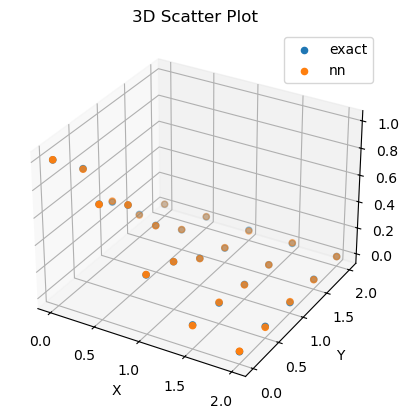

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

with torch.no_grad():
    # Extract x, y, and z coordinates
    x = grid[:, 0]
    y = grid[:, 1]
    z_1 = target.squeeze()  # Convert target tensor to 1D array
    z_2 = nn(grid).squeeze()  # Convert target tensor to 1D array

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot the points
    ax.scatter(x, y, z_1, label='exact')
    ax.scatter(x, y, z_2, label='nn')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot')


    plt.legend()
    plt.show()
